## Планы:
1. Гауссианы?
2. Нейронки из статей
3. Автоэнкодер?
4. Бустинг градиентный
5. Какой-нибудь другой feature engineering?
6. Посмотреть ROC AUC
7. Проверить устойчивость модели при изменении интенсивности!

## Выводы:
1. Данные становятся менее информативными при урезании/дополнении пиков, что отражается на качестве работы модели
2. Добавление в датасет информации и количестве значимых гауссианов ухудшает качество, что может свидетельствовать о возможно неправильном алгоритме разделения гауссианов на значимые и незначимые

## Инструкция для запускающих:
Инстукция предназначена для запуска на сервере 192.168.17.10
1. Убедись, что в качестве kernel'а выбрано raman-spec

In [67]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn.functional as F
from sklearn.model_selection import train_test_split

# strainforfard peaks search
import plotly.graph_objects as go
from scipy.signal import find_peaks, savgol_filter

# peaks search by gauss decomposition
# import gausspy
# import gausspy.gp as gp
# import pickle

from sklearn import metrics
from sklearn.ensemble import ExtraTreesClassifier

In [68]:
torch.cuda.is_available()

False

In [69]:
# !pip install plotly
# !pip install pandas
# !conda install pytorch torchvision torchaudio -c pytorch -y
# !pip install -U scikit-learn

## Data loading/proccessing

Загрузка данных

In [70]:
# # для работы в колабе 
# from google.colab import drive
# drive.mount('/content/drive')

### 38 peaks data proccessing

In [71]:
fixed_fg_file, fixed_ga_file = "dataSrc/peaks-fg-38nonsign.csv", "dataSrc/peaks-ga-38nonsign.csv"

data_fixed_fg = pd.read_csv(fixed_fg_file, sep=";", header=None)
data_fixed_ga = pd.read_csv(fixed_ga_file, sep=";", header=None)
columns = data_fixed_fg.columns
print(f"""data with fixed peaks FG shape: {data_fixed_fg.shape}
data with fixed peaks GA shape: {data_fixed_ga.shape}""")

data with fixed peaks FG shape: (569, 39)
data with fixed peaks GA shape: (89, 39)


In [72]:
y_fg = data_fixed_fg[columns[0]].values
print(f"old classes: {set(y_fg)}")
for index, element in enumerate(set(y_fg)):
    y_fg[y_fg == element] = index
print(f"new classes: {set(y_fg)}\n")

y_ga = data_fixed_ga[columns[0]].values
print(f"old ga classes: {set(y_ga)}")
for index, element in enumerate(set(data_fixed_ga[columns[0]])):
    y_ga[y_ga == element] = index + len(set(y_fg))
print(f"new ga classes: {set(y_ga)}")

old classes: {1, 2, 3, 4, 5, 7, 8, 9, 10, 11}
new classes: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

old ga classes: {2, 3, 5, 6}
new ga classes: {10, 11, 12, 13}


In [73]:
group1 = [0, 1, 2, 3, 4]
group2 = [5, 6, 7, 8, 9]
group3 = [10, 11]
group4 = [12, 13]
groups = [group1, group2, group3, group4]

def add_group(y, groups, add=0):
    new_y = np.zeros((y.shape[0], 2))
    new_y[:, 1] = y
    for group_num, group in enumerate(groups):
        for class_num in group:
            new_y[y==class_num] = np.array([group_num + add, class_num])
    return new_y

y_ga = add_group(y_ga, (group3, group4), add=2)
y_fg = add_group(y_fg, (group1, group2))
print(f"Now, shapes of y_fg and ga is respectively: {y_ga.shape}, {y_fg.shape}")

Now, shapes of y_fg and ga is respectively: (89, 2), (569, 2)


In [74]:
X_fixed = np.concatenate(
    (
    data_fixed_fg[columns[1:]],
    data_fixed_ga[columns[1:]]
    )
    , axis=0
)
y_fixed = np.concatenate(
    (
    y_fg,
    y_ga
    )
    , axis=0
)

print(f"shapes of X and y is respectively: {X_fixed.shape}, {y_fixed.shape}")

shapes of X and y is respectively: (658, 38), (658, 2)


### 1-40 peaks data proccessing

In [75]:
def read_file(filename, sep=';'):
    result = []
    with open(filename, 'r') as f:
        lines = f.read().splitlines()
#         print(len(strings))
    for line in lines:
        result.append(
            list(
                map(
                    float, 
                    line.split(sep)
                )
            )
        )
    return result

# read_file(nonfixed_fg_file)

In [76]:
nonfixed_fg_file, nonfixed_ga_file = "dataSrc/peaks-fg-1-40.csv", "dataSrc/peaks-ga-1-40.csv"

data_nonfixed_fg, data_nonfixed_ga = read_file(nonfixed_fg_file, sep=";"), read_file(nonfixed_ga_file, sep=";")

print(f"""data with nonfixed peaks FG shape: {len(data_nonfixed_fg)}
data with nonfixed peaks GA shape: {len(data_nonfixed_ga)}""")
data_nonfixed = data_nonfixed_fg + data_nonfixed_ga

X_nonfixed = [[len(x)] + x[1:] for x in data_nonfixed]
y_nonfixed = y_fixed.copy()
# y_nonfixed = [x[0] for data_nonfixed]

data with nonfixed peaks FG shape: 569
data with nonfixed peaks GA shape: 89


#### Добавим в датасет данные о количестве пиков 

In [77]:
# X_peaks = np.array([[len(x)] for x in data_nonfixed])
# # X_peaks
# X_fixed = np.concatenate((X_peaks, X_fixed), axis=1)

#### Создадим урезанный и дополненный датасеты:

In [78]:
min_size = 1e4
min_peaks = []
min_index = 0
max_size = 0
max_peaks = []
max_index = 0
for index, peaks in enumerate(X_nonfixed):
    if min_size > len(peaks):
        min_size = len(peaks)
        min_peaks = peaks
        min_index = index
    if max_size < len(peaks):
        max_size = len(peaks)
        max_peaks = peaks
        max_index = index

print(f"""min_size = {min_size}\n
max_size = {max_size}""")

min_size = 16

max_size = 40


In [79]:
def cut_peaks(X, min_size):
    new_data = []
    for example in X:
#         print(example)
        new_data.append(example[:min_size])
    return np.array(new_data)

X_nonfixed_cut = cut_peaks(X_nonfixed, min_size)
print(X_nonfixed_cut.shape)


def fill_peaks(X, max_size):
    new_data = []
    for example in X:
#         print(example)
        new_data.append(example+[0 for i in range(max_size - len(example))])
    return np.array(new_data)

X_nonfixed_filled = fill_peaks(X_nonfixed, max_size)
print(X_nonfixed_filled.shape)

(658, 16)
(658, 40)


## Применение методов ml

### Random Forest

In [80]:
def random_forest_train(data, y, num_features, description='data_cut dataset', class_type='group'):
    if class_type not in ('group', 'class'):
        raise Exception("class_type may be equal only 'group' or 'class'")
#     print(type(y))
    exrt_crystal_system = ExtraTreesClassifier(
        n_estimators=2000, 
        max_depth=40, 
        max_features=num_features, 
        n_jobs=-1, 
    #     random_state=random_state,
        warm_start=False
    )
    if class_type == 'group':
        X_peaks_train, X_peaks_test, y_peaks_train, y_peaks_test = train_test_split(data, 
                                                                                y[:, 0], 
                                                                                test_size=0.2
                                                                               )
    else:
        X_peaks_train, X_peaks_test, y_peaks_train, y_peaks_test = train_test_split(data, 
                                                                                y[:, 1], 
                                                                                test_size=0.2
                                                                               )  

    

    exrt_crystal_system.fit(X_peaks_train, y_peaks_train)
    y_pred = exrt_crystal_system.predict(X_peaks_test)
    accuracy = metrics.accuracy_score(y_peaks_test, y_pred)*100
    
    print(f'mean accuracy of {class_type} prediction on {description}: ', accuracy)

In [81]:
random_forest_train(
    X_nonfixed_cut, 
    y_nonfixed, 
    X_nonfixed_cut.shape[1], 
    class_type='group', 
    description='cut 15 peaks dataset'
)
random_forest_train(
    X_nonfixed_cut, 
    y_nonfixed, 
    X_nonfixed_cut.shape[1], 
    class_type='class', 
    description='cut 15 peaks dataset'
)


random_forest_train(
    X_nonfixed_filled, 
    y_nonfixed, 
    X_nonfixed_filled.shape[1], 
    class_type='group', 
    description='filled 40 peaks dataset'
)
random_forest_train(
    X_nonfixed_filled, 
    y_nonfixed, 
    X_nonfixed_filled.shape[1], 
    class_type='class', 
    description='filled 40 peaks dataset'
)

random_forest_train(
    X_fixed, 
    y_fixed, 
    X_fixed.shape[1], 
    class_type='group', 
    description='38 peaks dataset'
)
random_forest_train(
    X_fixed, 
    y_fixed, 
    X_fixed.shape[1], 
    class_type='class', 
    description='38 peaks dataset'
)

mean accuracy of group prediction on cut 15 peaks dataset:  96.21212121212122
mean accuracy of class prediction on cut 15 peaks dataset:  51.515151515151516
mean accuracy of group prediction on filled 40 peaks dataset:  93.93939393939394
mean accuracy of class prediction on filled 40 peaks dataset:  67.42424242424242
mean accuracy of group prediction on 38 peaks dataset:  100.0
mean accuracy of class prediction on 38 peaks dataset:  91.66666666666666


### Градиентный бустинг от XGBoost

In [82]:
# !pip install xgboost
import xgboost as xgb

In [83]:
def xgboost_train(data, y, num_features, description='data_cut dataset', class_type='group'):
    if class_type not in ('group', 'class'):
        raise Exception("class_type may be equal only 'group' or 'class'")
    
    xg_clsfr = xgb.XGBClassifier(
        objective='multi:softmax', 
        learning_rate = 0.01,
#         max_depth = 50, 
#         reg_alpha = 0, 
#         reg_lambda=0, 
        n_estimators = 1000, 
        eval_metric='merror'
#         num_class=7, 
#         tree_method = "hist", 
#         verbosity=0, 
#         grow_policy="lossguide"
    )
    if class_type == 'group':
        X_peaks_train, X_peaks_test, y_peaks_train, y_peaks_test = train_test_split(data, 
                                                                                y[:, 0], 
                                                                                test_size=0.2
                                                                               )
    else:
        X_peaks_train, X_peaks_test, y_peaks_train, y_peaks_test = train_test_split(data, 
                                                                                y[:, 1], 
                                                                                test_size=0.2
                                                                               )  
#     data_dmatrix = xgb.DMatrix(data=X_peaks_train, label=y_peaks_train)
    
    xg_clsfr.fit(X_peaks_train, y_peaks_train)
    y_pred = xg_clsfr.predict(X_peaks_test)
    accuracy = metrics.accuracy_score(y_peaks_test, y_pred)*100

    print(f'mean accuracy of {class_type} prediction on {description}: ', accuracy)

In [84]:
# in order to ignore all the warning messages
import warnings
warnings.filterwarnings('ignore')
# warnings.filterwarnings(action='once')

In [85]:
xgboost_train(X_nonfixed_cut, 
              y_nonfixed, 
              X_nonfixed_cut.shape[1], 
              class_type='group', 
              description='cut 15 peaks dataset')
xgboost_train(X_nonfixed_cut, 
              y_nonfixed, 
              X_nonfixed_cut.shape[1], 
              class_type='class', 
              description='cut 15 peaks dataset')

xgboost_train(X_nonfixed_filled, 
              y_nonfixed, 
              X_nonfixed_filled.shape[1], 
              class_type='group', 
              description='filled 40 peaks dataset')
xgboost_train(X_nonfixed_filled, 
              y_nonfixed, 
              X_nonfixed_filled.shape[1], 
              class_type='class', 
              description='filled 40 peaks dataset')

xgboost_train(X_fixed, 
              y_fixed, 
              X_fixed.shape[1], 
              class_type='group', 
              description='38 peaks dataset')
xgboost_train(X_fixed, 
              y_fixed, 
              X_fixed.shape[1], 
              class_type='class', 
              description='38 peaks dataset')

mean accuracy of group prediction on cut 15 peaks dataset:  93.93939393939394
mean accuracy of class prediction on cut 15 peaks dataset:  50.0
mean accuracy of group prediction on filled 40 peaks dataset:  98.48484848484848
mean accuracy of class prediction on filled 40 peaks dataset:  61.36363636363637
mean accuracy of group prediction on 38 peaks dataset:  99.24242424242425
mean accuracy of class prediction on 38 peaks dataset:  83.33333333333334


### Градиентный бустинг от CatBoost

In [86]:
# !pip install catboost
import catboost

In [87]:
def catboost_train(data, y, num_features, description='data_cut dataset', class_type='group'):
    if class_type not in ('group', 'class'):
        raise Exception("class_type may be equal only 'group' or 'class'")
    
#     yes, I love cats
    kitty_model = catboost.CatBoostClassifier(
        iterations = 1000,
#         if you want to see logs, set 'veerbose' to 1 or 2
        verbose=0
    )
    
    if class_type == 'group':
        X_peaks_train, X_peaks_test, y_peaks_train, y_peaks_test = train_test_split(data, 
                                                                                y[:, 0], 
                                                                                test_size=0.2
                                                                               )
    else:
        X_peaks_train, X_peaks_test, y_peaks_train, y_peaks_test = train_test_split(data, 
                                                                                y[:, 1], 
                                                                                test_size=0.2
                                                                               )  
#     data_dmatrix = xgb.DMatrix(data=X_peaks_train, label=y_peaks_train)
    
    kitty_model.fit(X_peaks_train, y_peaks_train)
    y_pred = kitty_model.predict(X_peaks_test)
    accuracy = metrics.accuracy_score(y_peaks_test, y_pred)*100

    print(f'mean accuracy of {class_type} prediction on {description}: ', accuracy)

In [88]:
# in order to ignore all the warning messages
# import warnings
# warnings.filterwarnings('ignore')
catboost_train(X_nonfixed_cut, 
              y_nonfixed, 
              X_nonfixed_cut.shape[1], 
              class_type='group', 
              description='cut 15 peaks dataset')
catboost_train(X_nonfixed_cut, 
              y_nonfixed, 
              X_nonfixed_cut.shape[1], 
              class_type='class', 
              description='cut 15 peaks dataset')

catboost_train(X_nonfixed_filled, 
              y_nonfixed, 
              X_nonfixed_filled.shape[1], 
              class_type='group', 
              description='filled 40 peaks dataset')
catboost_train(X_nonfixed_filled, 
              y_nonfixed, 
              X_nonfixed_filled.shape[1], 
              class_type='class', 
              description='filled 40 peaks dataset')

catboost_train(X_fixed, 
              y_fixed, 
              X_fixed.shape[1], 
              class_type='group', 
              description='38 peaks dataset')
catboost_train(X_fixed, 
              y_fixed, 
              X_fixed.shape[1], 
              class_type='class', 
              description='38 peaks dataset')

mean accuracy of group prediction on cut 15 peaks dataset:  93.18181818181817
mean accuracy of class prediction on cut 15 peaks dataset:  58.333333333333336
mean accuracy of group prediction on filled 40 peaks dataset:  95.45454545454545
mean accuracy of class prediction on filled 40 peaks dataset:  56.81818181818182
mean accuracy of group prediction on 38 peaks dataset:  99.24242424242425
mean accuracy of class prediction on 38 peaks dataset:  87.87878787878788


### Поиск пиков с помощью разложения на гауссианы находится в ноутбуке used_tools.ipynb

## ResNet 1-D

In [91]:
class block1d(nn.Module):
    def __init__(
        self,
        in_channels, 
        out_channels,
        downsample=None,
        stride=1,
        kernel_size=3, 
        padding=1
    ):
        super(block1d, self).__init__()
#         the last convolution outputs out_channels * self.expansion channels
#         It is done in order to save number of parameters. 
#         self.expansion = dimension * 2
        self.expansion = 2
        self.conv1 = nn.Conv1d(
            in_channels, 
            out_channels,
            kernel_size=1 ,
            stride=1,
            padding=0,
            bias=False
        )
        self.bn1 = nn.BatchNorm1d(out_channels)
        
        self.conv2 = nn.Conv1d(
            out_channels, 
            out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            bias=False
        )
        self.bn2 = nn.BatchNorm1d(out_channels)
        
        self.conv3 = nn.Conv1d(
            out_channels, 
            out_channels*self.expansion,
            kernel_size=1 ,
            stride=1,
            padding=0,
            bias=False
        )
        self.bn3 = nn.BatchNorm1d(out_channels*self.expansion)
        
        self.relu = nn.ReLU()
#         all the blocks in ResNet is devided by four groups, every next group is downsampled
#         in relation to previous one. This field is responsible for that
        self.downsample=downsample
    
    
    def forward(self, x):
#         in order to perform skip connection
        identity = x.clone()
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        
        if self.downsample is not None:
            identity = self.downsample(identity)
        
        x += identity
        x = self.relu(x)
        return x
        

class ResNet1d(nn.Module):
    def __init__(
        self,
        block,
        layers,
        num_classes,
        num_groups
    ):
        super(ResNet1d, self).__init__()
        self.expansion = 2
        self.in_channels = 64
        self.p = 0.02
        
        self.conv1 = nn.Conv1d(
            in_channels=1,
            out_channels=self.in_channels, 
            kernel_size=7, 
            stride=2, 
            padding=3, 
            bias=False
        )
        self.bn1 = nn.BatchNorm1d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(
            block1d, layers[0], out_channels=64, stride=1
        )
        self.layer2 = self._make_layer(
            block1d, layers[1], out_channels=128, stride=2
        )
        self.layer3 = self._make_layer(
            block1d, layers[2], out_channels=256, stride=2
        )
        self.layer4 = self._make_layer(
            block1d, layers[3], out_channels=512, stride=2
        )
        
        self.avgpool = nn.AdaptiveAvgPool1d(8)
        self.fc_class = nn.Sequential(
            nn.Linear(8192, num_classes),
            nn.Dropout(p=self.p)
        )
        self.fc_group = nn.Sequential(
            nn.Linear(8192, num_groups),
            nn.Dropout(p=self.p)
        )
        self.softmax = nn.Softmax(dim=-1)
        
        
    def _make_layer(self, block, num_residual_blocks, out_channels, stride):
        downsample = None
        layers = []
        
#         in order to adopt skip connection, we add downsample to the end of block group
        if stride != 1 or self.in_channels != out_channels * self.expansion:
            downsample = nn.Sequential(
                nn.Conv1d(
                    self.in_channels, 
                    out_channels*self.expansion,
                    kernel_size=1,
                    stride=stride,
                    bias=False
                ),
                nn.BatchNorm1d(out_channels*self.expansion)
            )
        
        layers.append(
            block1d(
                self.in_channels, 
                out_channels, 
                downsample, 
                stride
            )
        )
        
        self.in_channels = out_channels * self.expansion
        
        for i in range(num_residual_blocks - 1):
            layers.append(
                block1d(self.in_channels, out_channels)
            )
        
        return nn.Sequential(*layers)
    

    def get_features(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
#         x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        return x


    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        # print(x.shape)
        x = x.reshape(x.shape[0], -1)
        # print(x.shape)

        groups = self.fc_group(x)
        classes = self.fc_class(x)
        
        return (self.softmax(groups), self.softmax(classes))
#         return (groups, classes)


def ResNet50_1d(num_classes=14, num_groups=4):
    return ResNet1d(block1d, [3, 4, 6, 3], num_classes, num_groups)


def ResNet101_1d(num_classes=14, num_groups=4):
    return ResNet1d(block1d, [3, 4, 23, 3], num_classes, num_groups)


def ResNet152_1d(num_classes=14, num_groups=4):
    return ResNet1d(block1d, [3, 8, 36, 3], num_classes, num_groups)

In [80]:
# def test():
#     net = ResNet101_1d(num_classes=14, num_groups=4)
#     y = net(torch.randn(4, 1, 994))
#     return y


# y = test()

# y[0].size(), y[1].size()

In [81]:
# len(data_loader_train)

In [82]:
def train(model, optimizer, loss_func, epochs, train_loader, val_loader):
    train_history = []
    test_history = []
    
    for epoch in tqdm(range(epochs)):
        model.train()
        avg_train_loss = 0
        avg_test_loss = 0
        right_preds_group = 0
        right_preds_classes = 0
        size_group = 0
        size_classes = 0
        for X_batch, y_batch in tqdm(train_loader):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs_groups, outputs_classes = model(X_batch)
#             print(y_batch[:, 0].shape)
#             print(outputs_groups.shape)
            loss_group = loss_func(outputs_groups, y_batch[:, 0])
            loss_classes = loss_func(outputs_classes, y_batch[:, 1])
            loss = loss_group + loss_classes
            loss.backward()
            optimizer.step()
            optimizer.zero_grad
            avg_train_loss += loss / len(train_loader)
            
            y_pred_group = torch.argmax(outputs_groups, dim = 1)
            right_preds_group += torch.sum(y_pred_group == y_batch[:, 0])
            size_group += y_pred_group.size()[0]
            
            y_pred_classes = torch.argmax(outputs_classes, dim = 1)
#             print(y_pred_classes,y_batch[:, 1])
            right_preds_classes += torch.sum(y_pred_classes == y_batch[:, 1])
            size_classes += y_pred_classes.size()[0]
            
        train_acc_group = right_preds_group / size_group
        train_acc_classes = right_preds_classes / size_classes
        train_history.append(avg_train_loss)
        
        model.eval()
        right_preds_group = 0
        right_preds_classes = 0
        size_group = 0
        size_classes = 0
        for X_batch, y_batch in tqdm(val_loader):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            with torch.no_grad():
                outputs_groups, outputs_classes = model(X_batch)
                loss_group = loss_func(outputs_groups, y_batch[:, 0])
                loss_classes = loss_func(outputs_classes, y_batch[:, 1])
                loss = loss_group + loss_classes
    # outputs неправильный!!
                avg_test_loss += loss / len(val_loader)
#                 y_pred = torch.argmax(outputs, dim = 1)
#                 right_preds += torch.sum(y_pred == y_batch)
#                 size += y_pred.size()[0]
#         test_acc = right_preds / size
                y_pred_group = torch.argmax(outputs_groups, dim = 1)
                right_preds_group += torch.sum(y_pred_group == y_batch[:, 0])
                size_group += y_pred_group.size()[0]

                y_pred_classes = torch.argmax(outputs_classes, dim = 1)
                right_preds_classes += torch.sum(y_pred_classes == y_batch[:, 1])
                size_classes += y_pred_classes.size()[0]
            
        test_acc_group = right_preds_group / size_group
        test_acc_classes = right_preds_classes / size_classes
        
        test_history.append(avg_test_loss)
        print(f"""epochs: {epoch + 1}/{epochs}, 
        train loss: {round(avg_train_loss.item(), 3)}, test loss: {round(avg_test_loss.item(), 3)}
        train group accuracy: {round(train_acc_group.item() * 100, 2)}, test group accuracy: {round(test_acc_group.item() * 100, 2)}
        train class accuracy: {round(train_acc_classes.item() * 100, 2)}, test class accuracy: {round(test_acc_classes.item() * 100, 2)}""")
        torch.cuda.empty_cache()
#     
    return train_history, test_history

In [90]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ResNet50_1d().to(device)
optimizer = optim.Adam(model.parameters(), lr = 1e-4, weight_decay = 0.01)
# scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.75)
loss_function = nn.CrossEntropyLoss()
max_epochs = 5
train_hist, test_hist = train(
    model, 
    optimizer,
    loss_function,
    max_epochs,
    data_loader_train, 
    data_loader_test,
)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

epochs: 1/5, 
        train loss: 3.471, test loss: 3.548
        train group accuracy: 84.22, test group accuracy: 87.12
        train class accuracy: 19.2, test class accuracy: 12.88


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

epochs: 2/5, 
        train loss: 3.407, test loss: 3.441
        train group accuracy: 86.31, test group accuracy: 87.12
        train class accuracy: 20.91, test class accuracy: 17.42


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

epochs: 3/5, 
        train loss: 3.436, test loss: 3.447
        train group accuracy: 86.5, test group accuracy: 87.12
        train class accuracy: 19.39, test class accuracy: 18.18


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

epochs: 4/5, 
        train loss: 3.449, test loss: 3.449
        train group accuracy: 86.31, test group accuracy: 87.12
        train class accuracy: 18.44, test class accuracy: 18.18


  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

epochs: 5/5, 
        train loss: 3.451, test loss: 3.45
        train group accuracy: 86.12, test group accuracy: 87.12
        train class accuracy: 18.44, test class accuracy: 18.18


In [84]:
def visualise_loss(train_hisoryt, test_history):
    pass

In [86]:
visualise_loss(train_hist, test_hist)

## Кластеризация

### Base approach

/Users/Lazarev/opt/anaconda3/envs/gausspy/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/Users/Lazarev/opt/anaconda3/envs/gausspy/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



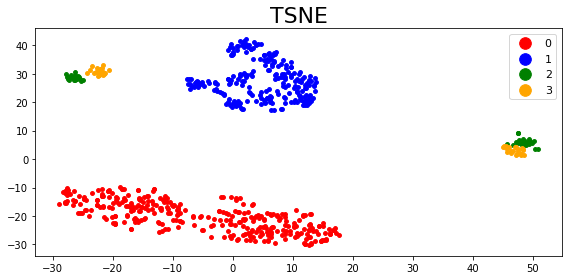

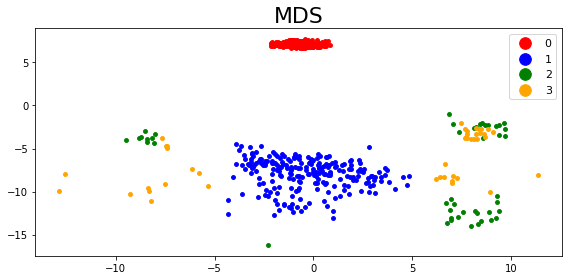

/Users/Lazarev/opt/anaconda3/envs/gausspy/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning:

The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).

/Users/Lazarev/opt/anaconda3/envs/gausspy/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning:

Maximum number of iterations 200 reached. Increase it to improve convergence.



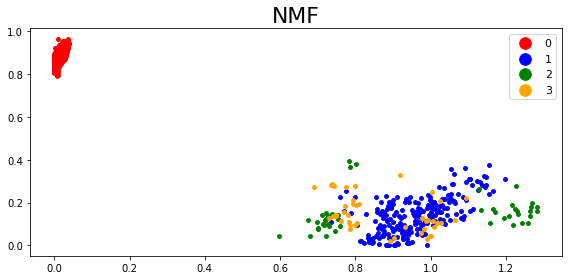

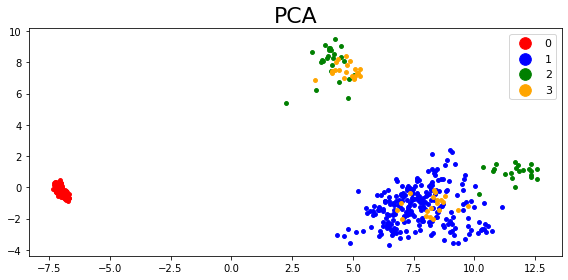

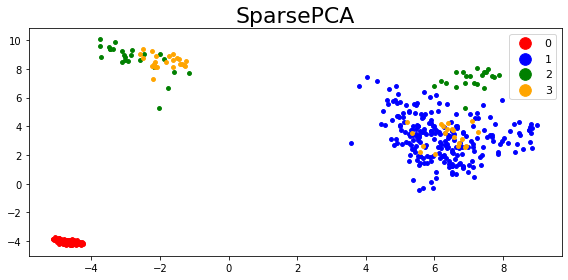

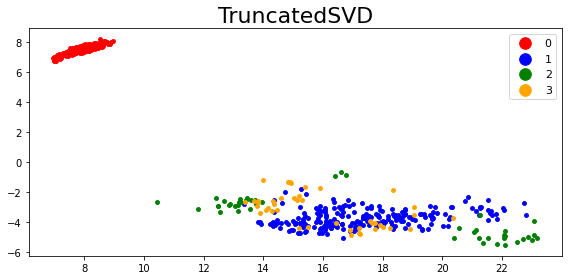

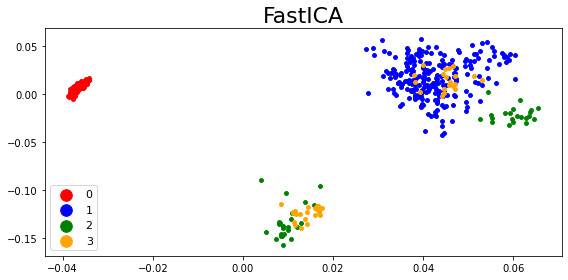

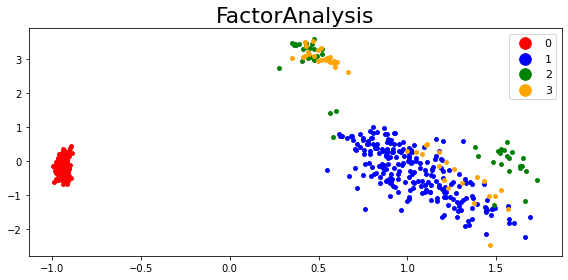

In [38]:
from sklearn.manifold import TSNE, MDS
from sklearn.decomposition import PCA, NMF, SparsePCA, TruncatedSVD, FastICA, FactorAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline


# random_state = 42
cdict = {0: 'red',1: 'blue', 2: 'green', 3: 'orange'}

def plot_destribution(X_embedded, y, titleName):
    fig, ax = plt.subplots(figsize=(8,4))
    for iy in np.unique(y):
        ix = np.where(y == iy)
        x1data = X_embedded[:, 0]
        x2data = X_embedded[:, 1]
        ax.scatter(x1data[ix], x2data[ix], c = cdict[iy], label = str(int(iy)), s = 15)
    ax.legend(fontsize=11, markerscale=3)
    ax.set_title(titleName, size=22)
    plt.tight_layout()
    plt.show()  

# sklearn.manifold:
X_tsne = TSNE(n_components=2).fit_transform(X.reshape(X.shape[0], X.shape[2]))
plot_destribution(X_tsne, y[:, 0], 'TSNE')

X_pca = MDS(n_components=2).fit_transform(X.reshape(X.shape[0], X.shape[2]))
plot_destribution(X_pca, y[:, 0], 'MDS')

# sklearn.decomposition
X_pca = NMF(n_components=2).fit_transform(X.reshape(X.shape[0], X.shape[2]))
plot_destribution(X_pca, y[:, 0], 'NMF')

X_pca = PCA(n_components=2).fit_transform(X.reshape(X.shape[0], X.shape[2]))
plot_destribution(X_pca, y[:, 0], 'PCA')

X_pca = SparsePCA(n_components=2).fit_transform(X.reshape(X.shape[0], X.shape[2]))
plot_destribution(X_pca, y[:, 0], 'SparsePCA')

X_pca = TruncatedSVD(n_components=2).fit_transform(X.reshape(X.shape[0], X.shape[2]))
plot_destribution(X_pca, y[:, 0], 'TruncatedSVD')

X_pca = FastICA(n_components=2).fit_transform(X.reshape(X.shape[0], X.shape[2]))
plot_destribution(X_pca, y[:, 0], 'FastICA')

X_pca = FactorAnalysis(n_components=2).fit_transform(X.reshape(X.shape[0], X.shape[2]))
plot_destribution(X_pca, y[:, 0], 'FactorAnalysis')

/Users/Lazarev/opt/anaconda3/envs/gausspy/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/Users/Lazarev/opt/anaconda3/envs/gausspy/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



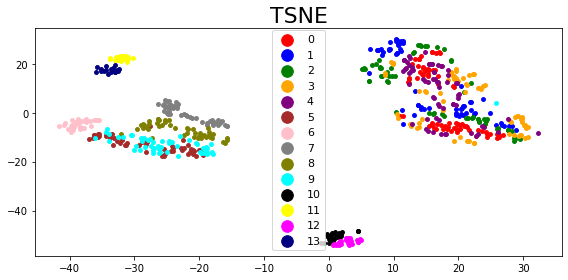

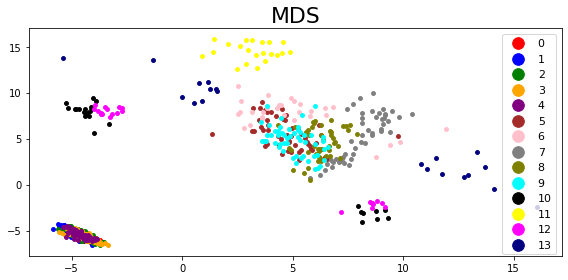

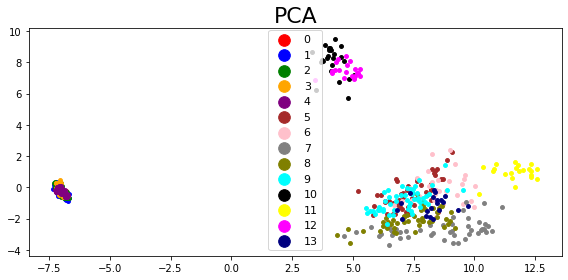

/Users/Lazarev/opt/anaconda3/envs/gausspy/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning:

The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).

/Users/Lazarev/opt/anaconda3/envs/gausspy/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning:

Maximum number of iterations 200 reached. Increase it to improve convergence.



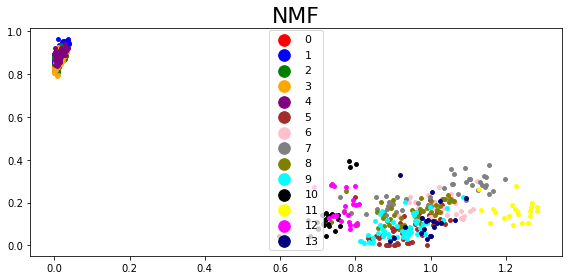

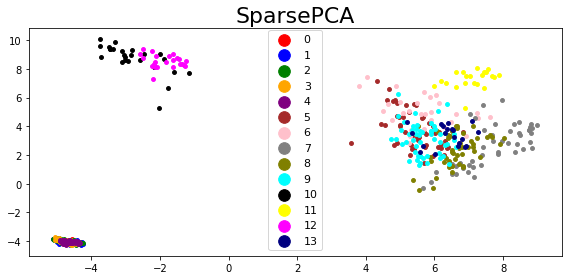

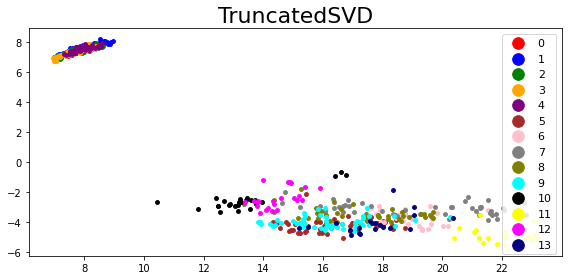

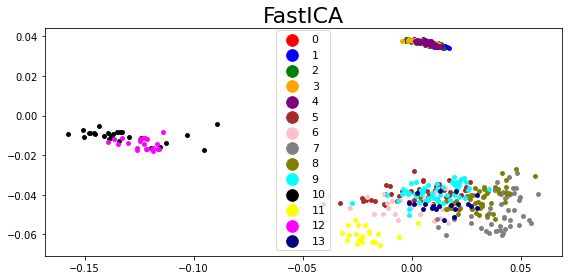

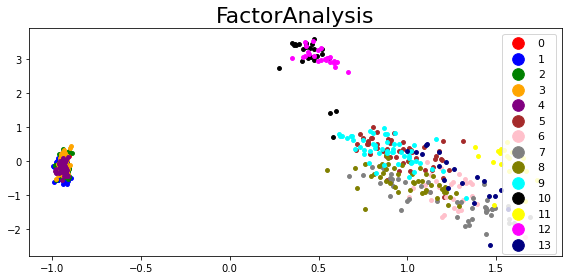

In [39]:
cdict = {
    0: 'red',
    1: 'blue', 
    2: 'green', 
    3: 'orange',
    4: 'purple',
    5: 'brown',
    6: 'pink',
    7: 'gray',
    8: 'olive',
    9: 'cyan',
    10: 'black',
    11: 'yellow',
    12: 'fuchsia',
    13: 'navy' 
    }

# sklearn.manifold:
X_tsne = TSNE(n_components=2).fit_transform(X.reshape(X.shape[0], X.shape[2]))
plot_destribution(X_tsne, y[:, 1], 'TSNE')

X_pca = MDS(n_components=2).fit_transform(X.reshape(X.shape[0], X.shape[2]))
plot_destribution(X_pca, y[:, 1], 'MDS')

# sklearn.decomposition
X_pca = PCA(n_components=2).fit_transform(X.reshape(X.shape[0], X.shape[2]))
plot_destribution(X_pca, y[:, 1], 'PCA')

X_pca = NMF(n_components=2).fit_transform(X.reshape(X.shape[0], X.shape[2]))
plot_destribution(X_pca, y[:, 1], 'NMF')

X_pca = SparsePCA(n_components=2).fit_transform(X.reshape(X.shape[0], X.shape[2]))
plot_destribution(X_pca, y[:, 1], 'SparsePCA')

X_pca = TruncatedSVD(n_components=2).fit_transform(X.reshape(X.shape[0], X.shape[2]))
plot_destribution(X_pca, y[:, 1], 'TruncatedSVD')

X_pca = FastICA(n_components=2).fit_transform(X.reshape(X.shape[0], X.shape[2]))
plot_destribution(X_pca, y[:, 1], 'FastICA')

X_pca = FactorAnalysis(n_components=2).fit_transform(X.reshape(X.shape[0], X.shape[2]))
plot_destribution(X_pca, y[:, 1], 'FactorAnalysis')

### CNN aproach

In [40]:
def make_features(model, X):
    result = []
    data_loader = DataLoader(
        torch.tensor(X).float(), 
        batch_size=16, 
        shuffle=True
    )
    model.eval()
    with torch.no_grad():
        for data in data_loader:
            # print(data.shape)
            # print(model.get_features(data).shape)
            result.append(model.get_features(data))
    return torch.cat(result, dim=0).numpy()

/Users/Lazarev/opt/anaconda3/envs/gausspy/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/Users/Lazarev/opt/anaconda3/envs/gausspy/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



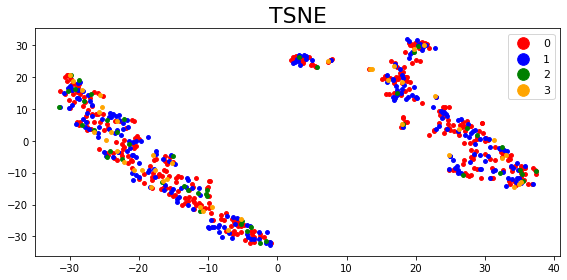

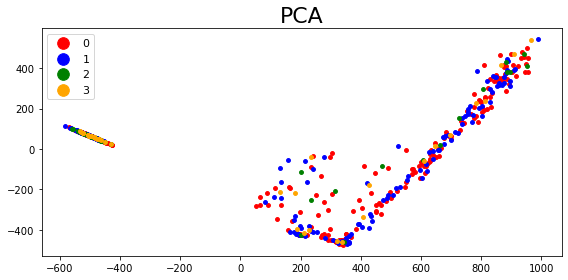

In [42]:
cdict = {
    0: 'red',
    1: 'blue', 
    2: 'green', 
    3: 'orange',
    }

X_features = make_features(model, X)

X_tsne = TSNE(n_components=2).fit_transform(X_features)
plot_destribution(X_tsne, y[:, 0], 'TSNE')

X_pca = PCA(n_components=2).fit_transform(X_features)
plot_destribution(X_pca, y[:, 0], 'PCA')